In [1]:
from functools import partial
from typing import Any

import jax
import jax.numpy as jnp
import flax.linen as nn
import flax
from flax.training import train_state
import optax
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

import cv2
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
ds = tfds.load('cifar10')
train_ds = ds['train']
test_ds = ds['test']
print(train_ds)
print(test_ds)

<PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>
<PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>


In [3]:
train_data_size = len(train_ds)
test_data_size = len(test_ds)

print('train data size: ', train_data_size)
print('test data size: ', test_data_size)

train data size:  50000
test data size:  10000


### Notes

I notice something really strange when using tfds. It seems like if the output of the dataset is referenced in some way, the tensor seems to be stuck in memory. So if I have something like this:
```python
def mapping(x):
    image = ...
    return image

ds = ds.map(mapping)
```

the `image` tensor will be stuck in memory, which if the image is large, will be a problem

In this case, my implementation is to do augmentation after getting data from dataset

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

def preprocess_ds(ds):
    ds = ds.repeat()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.batch(BATCH_SIZE)
    return ds


STEP_PER_EPOCH = train_data_size // BATCH_SIZE
print('step per epoch: ', STEP_PER_EPOCH)
train_ds = preprocess_ds(train_ds)
test_ds = preprocess_ds(test_ds)
print(train_ds)
print(test_ds)

step per epoch:  1562
<BatchDataset shapes: {id: (None,), image: (None, 32, 32, 3), label: (None,)}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>
<BatchDataset shapes: {id: (None,), image: (None, 32, 32, 3), label: (None,)}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>


In [5]:
transform = A.Compose([
    A.Flip(),
    A.OpticalDistortion(),
    A.ColorJitter(),
    A.CoarseDropout(),
])

def get_iter(ds, training=True):
    ds_iter = iter(ds)
    def _process(x):
        images = x['image']._numpy()
        labels = x['label']._numpy()
        resized = []
        for image in images:
            img = cv2.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
            if training:
                img = transform(image=img)['image']
            resized.append(img)
        return {'image': np.array(resized), 'label': labels}
    
    # ds_iter = map(lambda x: jax.tree_map(lambda t: np.asarray(memoryview(t)), x),
    #               ds_iter)
    # ds_iter = map(lambda x: jax.tree_map(lambda t: np.array(t), x),
    #               ds_iter)
    ds_iter = map(_process, ds_iter)
    return ds_iter


train_iter = get_iter(train_ds)
test_iter = get_iter(test_ds)

test_batch = next(train_iter)
print(test_batch['image'].shape, test_batch['image'].dtype)
print(test_batch['label'].shape)

(32, 224, 224, 3) uint8
(32,)


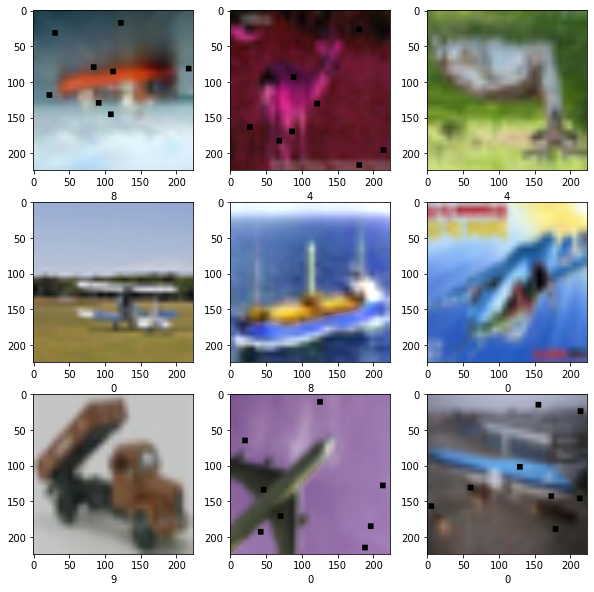

In [6]:
train_iter = get_iter(train_ds)
test_example = next(train_iter)
test_images = test_example['image'] / 255.0
test_labels = test_example['label']

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i, ...])
    plt.xlabel(str(test_labels[i]))
plt.show()

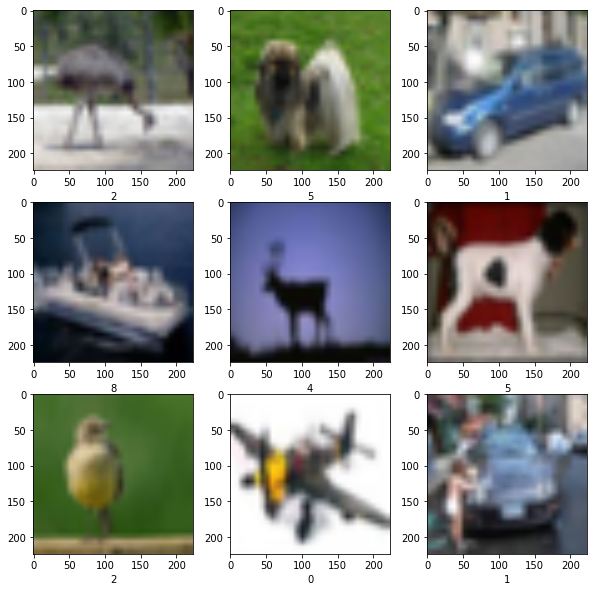

In [7]:
test_iter = get_iter(test_ds, training=False)

test_example = next(test_iter)
test_images = test_example['image'] / 255.0
test_labels = test_example['label']

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i, ...])
    plt.xlabel(str(test_labels[i]))
plt.show()

In [8]:
def test_iterator():
    for _ in range(STEP_PER_EPOCH):
        batch = next(train_iter)
        pass


%time test_iterator()

CPU times: user 2min 6s, sys: 21 s, total: 2min 27s
Wall time: 27.5 s


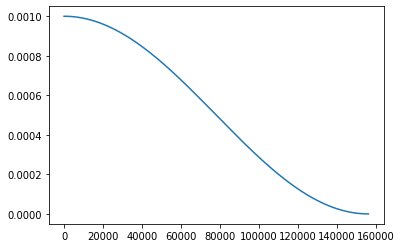

In [9]:
def create_lr_func():
    return optax.cosine_decay_schedule(1e-3, STEP_PER_EPOCH * 100)


t = np.arange(STEP_PER_EPOCH * 100)
y = create_lr_func()(t)
plt.plot(t, y)
plt.show()

In [10]:
class TrainState(train_state.TrainState):
    batch_stats: Any


class CNN(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool = True):
        Conv = partial(nn.Conv, use_bias=False)
        BN = partial(nn.BatchNorm, use_running_average=not train)
        Drop = partial(nn.Dropout, rate=0.5, deterministic=True)
        Pool = partial(nn.max_pool, window_shape=(2, 2), strides=(2, 2), padding='SAME')
        
        x /= 255.0
        for depth in [32, 64, 96, 128, 256]:
            x = Conv(32, kernel_size=(3, 3))(x)
            x = BN()(x)
            x = Drop()(x)
            x = nn.relu(x)
            x = Pool(x)
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)
        return x


def create_train_state(model, key):
    input_shape = [1, IMAGE_SIZE, IMAGE_SIZE, 3]
    variables = model.init({'params': key}, jnp.ones(input_shape, dtype=jnp.float32))
    tx = optax.adam(create_lr_func())
    return TrainState.create(apply_fn=model.apply,
                             params=variables['params'],
                             tx=tx,
                             batch_stats=variables['batch_stats'])


model = CNN()
key = jax.random.PRNGKey(666)
state = create_train_state(model, key)

In [11]:
def loss_fn(logits, labels, params):
    l = jax.nn.one_hot(labels, num_classes=10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=l))
    # W_params = jax.tree_leaves(params)
    # W_l2 = sum([jnp.sum(x ** 2) for x in W_params if x.ndim > 1])
    # loss = loss + 1e-4 * W_l2 * 0.5
    return loss


@jax.jit
def train_step(state, batch):
    images = batch['image']
    labels = batch['label']
    
    def compute_loss(params, batch_stats):
        logits, new_model_state = state.apply_fn(
            {'params': params, 'batch_stats': batch_stats},
            images,
            mutable=['batch_stats'])
        loss = loss_fn(logits, labels, state.params)
        return loss, (new_model_state, logits)
    
    grad_fn = jax.value_and_grad(compute_loss, has_aux=True)
    aux, grads = grad_fn(state.params, state.batch_stats)
    loss, (new_model_state, logits) = aux
    new_state = state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats'])
    return new_state, loss



test_example = next(train_iter)
test_state, loss = train_step(state, test_example)
print(loss)

2.6861675


In [12]:
## %timeit train_step(state, test_example['image'], test_example['label'])

In [13]:
@jax.jit
def eval_model(state, batch):
    logits = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        batch['image'],
        train=False,
        mutable=False)
    
    loss = loss_fn(logits, batch['label'], state.params)
    accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == batch['label'])
    return {
        'loss': loss,
        'accuracy': accuracy,
    }


test_metrics = eval_model(state, test_example)
print(test_metrics)

{'accuracy': DeviceArray(0.03125, dtype=float32), 'loss': DeviceArray(2.3203907, dtype=float32)}


In [14]:
LOG_PER_STEP = 200


def train_and_eval(state, num_epochs=10):
    train_iter = get_iter(train_ds)
    test_iter = get_iter(test_ds, training=False)
    for epoch in range(num_epochs):
        train_metrics = []
        for step in range(STEP_PER_EPOCH):
            batch = next(train_iter)
            state, _ = train_step(state, batch)
            metrics = eval_model(state, batch)
            train_metrics.append(metrics)
            if step % LOG_PER_STEP == 0:
                loss = jnp.average([m['loss'] for m in train_metrics])
                accuracy = jnp.average([m['accuracy'] for m in train_metrics])
                print(f"{epoch+1}.{step} loss: {loss}, accuracy: {accuracy}")
        
        val_metrics = []
        for _ in range(test_data_size // BATCH_SIZE):
            test_batch = next(test_iter)
            metrics = eval_model(state, test_batch)
            val_metrics.append(metrics)
        
        val_loss = jnp.average([m['loss'] for m in val_metrics])
        val_accuracy = jnp.average([m['accuracy'] for m in val_metrics])
        print(f'validation loss: {val_loss}, accuracy: {val_accuracy}')
    return state


model = CNN()
key = jax.random.PRNGKey(666)
state = create_train_state(model, key)
done_state = train_and_eval(state, 100)

1.0 loss: 2.2394328117370605, accuracy: 0.21875
1.200 loss: 2.132105588912964, accuracy: 0.20055969059467316
1.400 loss: 1.9944026470184326, accuracy: 0.25623443722724915
1.600 loss: 1.8933738470077515, accuracy: 0.29232528805732727
1.800 loss: 1.832987904548645, accuracy: 0.3159331977367401
1.1000 loss: 1.782203197479248, accuracy: 0.33738136291503906
1.1200 loss: 1.7476415634155273, accuracy: 0.3531692326068878
1.1400 loss: 1.72292959690094, accuracy: 0.3636465072631836
validation loss: 1.3619225025177002, accuracy: 0.5082131624221802
2.0 loss: 1.484076738357544, accuracy: 0.34375
2.200 loss: 1.4599517583847046, accuracy: 0.46626242995262146
2.400 loss: 1.438261866569519, accuracy: 0.47841334342956543
2.600 loss: 1.448276162147522, accuracy: 0.4772774279117584
2.800 loss: 1.4274250268936157, accuracy: 0.48334112763404846
2.1000 loss: 1.4172443151474, accuracy: 0.48763734102249146
2.1200 loss: 1.407112717628479, accuracy: 0.4921419620513916
2.1400 loss: 1.3910897970199585, accuracy: 0

16.400 loss: 0.8702446222305298, accuracy: 0.691942036151886
16.600 loss: 0.8613760471343994, accuracy: 0.6930116415023804
16.800 loss: 0.8608774542808533, accuracy: 0.6929619312286377
16.1000 loss: 0.8527064919471741, accuracy: 0.6939622759819031
16.1200 loss: 0.8538024425506592, accuracy: 0.695071816444397
16.1400 loss: 0.8548736572265625, accuracy: 0.6952400207519531
validation loss: 0.7949934601783752, accuracy: 0.7202523946762085
17.0 loss: 0.7843630909919739, accuracy: 0.65625
17.200 loss: 0.8578143119812012, accuracy: 0.6955845355987549
17.400 loss: 0.8527167439460754, accuracy: 0.6951372027397156
17.600 loss: 0.8371647000312805, accuracy: 0.6997711658477783
17.800 loss: 0.8360120058059692, accuracy: 0.7017790079116821
17.1000 loss: 0.8255494236946106, accuracy: 0.7057005167007446
17.1200 loss: 0.827925980091095, accuracy: 0.7051935791969299
17.1400 loss: 0.8235316276550293, accuracy: 0.706392765045166
validation loss: 0.8251538276672363, accuracy: 0.7124398946762085
18.0 loss: 

31.400 loss: 0.726718544960022, accuracy: 0.7451683282852173
31.600 loss: 0.7176334857940674, accuracy: 0.7471401691436768
31.800 loss: 0.7156671285629272, accuracy: 0.7464497089385986
31.1000 loss: 0.7109172344207764, accuracy: 0.7484078407287598
31.1200 loss: 0.7140102982521057, accuracy: 0.7477622628211975
31.1400 loss: 0.7119865417480469, accuracy: 0.7485947608947754
validation loss: 0.8937990069389343, accuracy: 0.6949118971824646
32.0 loss: 0.9763836860656738, accuracy: 0.65625
32.200 loss: 0.6847156882286072, accuracy: 0.7588618993759155
32.400 loss: 0.6902461647987366, accuracy: 0.7542082667350769
32.600 loss: 0.706169843673706, accuracy: 0.7487520575523376
32.800 loss: 0.7031970620155334, accuracy: 0.7500389814376831
32.1000 loss: 0.7123227715492249, accuracy: 0.7466908097267151
32.1200 loss: 0.7148092985153198, accuracy: 0.7470076680183411
32.1400 loss: 0.7113946080207825, accuracy: 0.7484832406044006
validation loss: 0.9218167066574097, accuracy: 0.6882011294364929
33.0 loss

46.400 loss: 0.653541088104248, accuracy: 0.7745480537414551
46.600 loss: 0.6476348042488098, accuracy: 0.776726245880127
46.800 loss: 0.6444937586784363, accuracy: 0.776490330696106
46.1000 loss: 0.6376878023147583, accuracy: 0.7785651683807373
46.1200 loss: 0.6365775465965271, accuracy: 0.778700053691864
46.1400 loss: 0.633080780506134, accuracy: 0.7800008654594421
validation loss: 0.7143087983131409, accuracy: 0.7597155570983887
47.0 loss: 0.5035131573677063, accuracy: 0.78125
47.200 loss: 0.6013380885124207, accuracy: 0.7946206331253052
47.400 loss: 0.6187766790390015, accuracy: 0.7869389057159424
47.600 loss: 0.620714545249939, accuracy: 0.7859816551208496
47.800 loss: 0.6272128224372864, accuracy: 0.7820302844047546
47.1000 loss: 0.6252478957176208, accuracy: 0.7824987173080444
47.1200 loss: 0.625876247882843, accuracy: 0.7816402912139893
47.1400 loss: 0.6238707900047302, accuracy: 0.7826329469680786
validation loss: 0.7378185987472534, accuracy: 0.7467948794364929
48.0 loss: 0.4

61.400 loss: 0.5653247237205505, accuracy: 0.8024470210075378
61.600 loss: 0.5685500502586365, accuracy: 0.800280749797821
61.800 loss: 0.5678562521934509, accuracy: 0.8010299205780029
61.1000 loss: 0.5684969425201416, accuracy: 0.8002622127532959
61.1200 loss: 0.5693643689155579, accuracy: 0.79988032579422
61.1400 loss: 0.5691183805465698, accuracy: 0.8003211617469788
validation loss: 0.7123832702636719, accuracy: 0.7559094429016113
62.0 loss: 0.655495285987854, accuracy: 0.84375
62.200 loss: 0.5427990555763245, accuracy: 0.8103233575820923
62.400 loss: 0.5544821619987488, accuracy: 0.8065773248672485
62.600 loss: 0.5604604482650757, accuracy: 0.8031405806541443
62.800 loss: 0.5641172528266907, accuracy: 0.800639808177948
62.1000 loss: 0.5608956217765808, accuracy: 0.8014797568321228
62.1200 loss: 0.5624334216117859, accuracy: 0.8019358515739441
62.1400 loss: 0.5643558502197266, accuracy: 0.8013472557067871
validation loss: 0.6705668568611145, accuracy: 0.770432710647583
63.0 loss: 0.

76.400 loss: 0.5265197157859802, accuracy: 0.8199033737182617
76.600 loss: 0.5266077518463135, accuracy: 0.8184276223182678
76.800 loss: 0.5289983153343201, accuracy: 0.8164793848991394
76.1000 loss: 0.5257219672203064, accuracy: 0.8173076510429382
76.1200 loss: 0.525891900062561, accuracy: 0.8177820444107056
76.1400 loss: 0.5263607501983643, accuracy: 0.8177194595336914
validation loss: 0.6750829815864563, accuracy: 0.7719351053237915
77.0 loss: 0.6309998035430908, accuracy: 0.75
77.200 loss: 0.5267437696456909, accuracy: 0.8188743591308594
77.400 loss: 0.5283362865447998, accuracy: 0.8140586018562317
77.600 loss: 0.52698814868927, accuracy: 0.8137478828430176
77.800 loss: 0.5279102325439453, accuracy: 0.8132022023200989
77.1000 loss: 0.5256786346435547, accuracy: 0.8147789239883423
77.1200 loss: 0.527214527130127, accuracy: 0.8139570951461792
77.1400 loss: 0.5257293581962585, accuracy: 0.8148420453071594
validation loss: 0.6635680794715881, accuracy: 0.7703325152397156
78.0 loss: 0.4

91.400 loss: 0.5044465065002441, accuracy: 0.8217737078666687
91.600 loss: 0.5051040649414062, accuracy: 0.821963369846344
91.800 loss: 0.5082904100418091, accuracy: 0.8203027248382568
91.1000 loss: 0.5063956379890442, accuracy: 0.82130366563797
91.1200 loss: 0.5063764452934265, accuracy: 0.8221274018287659
91.1400 loss: 0.5036247968673706, accuracy: 0.8228497505187988
validation loss: 0.6528417468070984, accuracy: 0.7763421535491943
92.0 loss: 0.5905940532684326, accuracy: 0.78125
92.200 loss: 0.48682770133018494, accuracy: 0.8361318111419678
92.400 loss: 0.49640989303588867, accuracy: 0.8292550444602966
92.600 loss: 0.4982522130012512, accuracy: 0.8275790214538574
92.800 loss: 0.5035489797592163, accuracy: 0.8254525661468506
92.1000 loss: 0.5042197108268738, accuracy: 0.8253620862960815
92.1200 loss: 0.5034731030464172, accuracy: 0.8258742690086365
92.1400 loss: 0.5032190680503845, accuracy: 0.8259947896003723
validation loss: 0.6531839966773987, accuracy: 0.776442289352417
93.0 loss